[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 274 samples in 0.000s...
[t-SNE] Computed neighbors for 274 samples in 0.000s...
[t-SNE] Computed conditional probabilities for sample 274 / 274
[t-SNE] Mean sigma: 414.194889
[t-SNE] KL divergence after 250 iterations with early exaggeration: 45.757504
[t-SNE] KL divergence after 1000 iterations: 0.091137


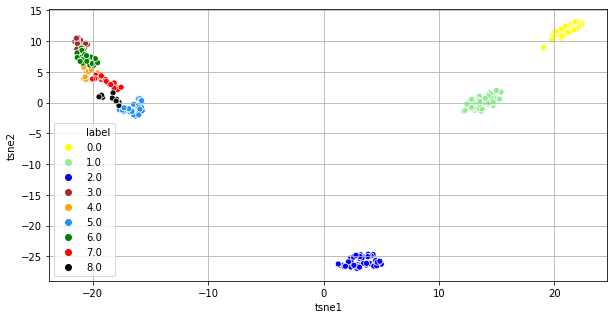

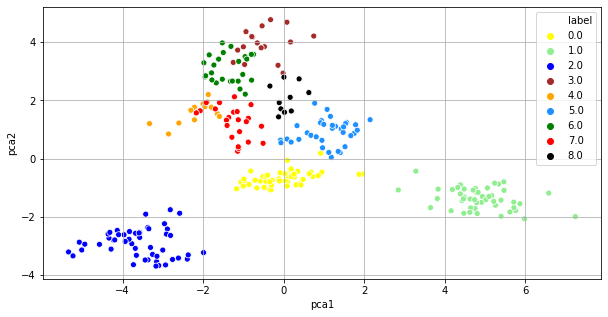

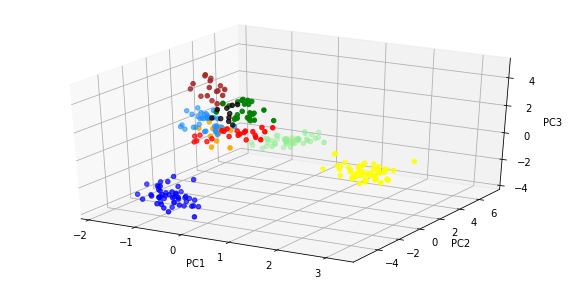

In [52]:
from __future__ import print_function
import time
import numpy as np
import pandas as pd
from sklearn.datasets import fetch_mldata
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
# %matplotlib notebook
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from sklearn.preprocessing import StandardScaler

tdata = np.loadtxt("truedataKmeans.txt")
X = tdata[:,0:15]
Y = tdata[:,15].reshape(X.shape[0],1)
X_std = StandardScaler().fit_transform(X)
# implement PCA
pca = PCA(n_components=3)
principalComponents = pca.fit_transform(X_std)
pca_df = pd.DataFrame({'pca1':principalComponents[:,0],'pca2':principalComponents[:,1],'pca3':principalComponents[:,2],'label':Y[:,0]})
pca_df.head()

#implement T-SNE
tsne = TSNE(n_components=2, random_state=0,verbose=1, perplexity=40, n_iter=1000)
tsne_result= tsne.fit_transform(X)
tsne_df = pd.DataFrame({'tsne1':tsne_result[:,0],'tsne2':tsne_result[:,1],'label':Y[:,0]})
tsne_df.head()

#plot TSNE 2d
fig = plt.figure(figsize=(10,5))
sns.scatterplot('tsne1', 'tsne2',
                hue='label',
                palette=['yellow','lightgreen','blue','brown','orange',
                       'dodgerblue','green','red','black'],
                data=tsne_df,
                legend="full")
plt.grid()
fig.savefig('tsne_2_pubjab.png')

#plot PCA 2
fig = plt.figure(figsize=(10,5))
sns.scatterplot('pca1', 'pca2',
                hue='label',
                palette=['yellow','lightgreen','blue','brown','orange',
                       'dodgerblue','green','red','black'],
                data=pca_df,
                legend="full")
plt.grid()
fig.savefig('pca_2_punjab.png')

#plot PCA 3
LABEL_COLOR_MAP = {0 : 'yellow',1 : 'lightgreen', 2:'blue', 3:'brown', 4:'orange',5:'dodgerblue', 6:'green', 7:'red',8:'black'}
label_color = [LABEL_COLOR_MAP[l] for l in Y[:,0]]
gph = plt.figure(figsize=(10,5)).gca(projection='3d')
gph.scatter(pca_df.pca3, pca_df.pca1, pca_df.pca2, c = label_color)
gph.set_xlabel('PC1')
gph.set_ylabel('PC2')
gph.set_zlabel('PC3')
plt.grid()


In [2]:
print(pca.components_)

[[ 0.28368394  0.26345818  0.30431137  0.29307108  0.32569024  0.29907661
   0.26630846  0.25812254  0.26101123  0.22614368 -0.0588115   0.34047042
   0.31328805 -0.01682788  0.03833327]
 [-0.23031875 -0.17634393 -0.22249829 -0.24112972 -0.15453836  0.23763374
   0.28809367  0.30334284  0.30419819  0.34143579  0.33236099 -0.01807438
  -0.20615018  0.28068439  0.33414555]
 [ 0.00459636  0.40839369 -0.05590667 -0.02931044 -0.07474299 -0.11288604
  -0.12051056 -0.11435705 -0.08996885 -0.09019065 -0.38247521  0.10799962
   0.0399593   0.60718613  0.48869931]]


[[50.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 1. 49.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0. 50.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0. 15.  0.  0.  2.  0.  0.]
 [ 0.  0.  0.  0. 13.  0.  0.  1.  0.]
 [ 0.  0.  0.  0.  0. 35.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0. 25.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0. 23.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0. 10.]]
98.54014598540147
0.9767693744164332
0.9849612684580005


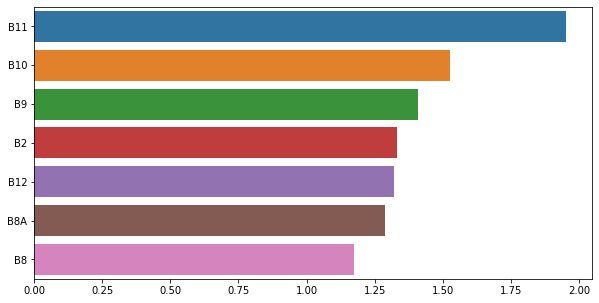

In [141]:
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.feature_selection import RFE

X = tdata[:,[1,7,8,9,10,11,12]]
# X = tdata[:,0:15]
Y = tdata[:,15].reshape(X.shape[0],1)

skf = StratifiedKFold(n_splits=10)
skf.get_n_splits(X)
Y = Y.reshape(X.shape[0],)
finalCf =np.zeros(9)
classes = 9
f = 0
# names = ['B1','B2', 'B3', 'B4', 'B5', 'B6','B7','B8','B8A','B9','B10','B11', 'B12','VH','VV'];
names = ['B2','B8','B8A','B9','B10','B11','B12']
for train_index, test_index in skf.split(X,Y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = Y[train_index], Y[test_index]

    #training and testing with Random Forests
    rf = RandomForestClassifier(n_estimators=100)
    rf.fit(X_train, y_train)
    predictions = rf.predict(X_test)
    cf = confusion_matrix(y_test, predictions)
    finalCf = finalCf + cf
    
    #feature importance besed on random forests
    feature_imp = pd.Series(rf.feature_importances_,index=names).sort_values(ascending=False)
#     fig = plt.figure(figsize=(10,5))
#     sns.barplot(x=feature_imp, y=feature_imp.index)    
    f = f+feature_imp

f = f.sort_values(ascending=False) 
fig = plt.figure(figsize=(10,5))
sns.barplot(x=f, y=feature_imp.index)    
print(finalCf)
TP = np.diagonal(finalCf)
accuracy = (np.trace(finalCf)/Y.shape[0])*100
precision = np.sum(np.divide(TP,np.sum(finalCf,axis=1)))/classes
recall = np.sum(np.divide(TP,np.sum(finalCf,axis=0)))/classes
print(accuracy)
print(precision)
print(recall)

